## Evaluation of student summaries
### This notebook contains code and results of training modified bidirectional transformer BERT for regression task.
The data was taken from kaggle: https://www.kaggle.com/competitions/commonlit-evaluate-student-summaries  
The goal is to assess the quality of summaries written by students in grades 3-12. The model evaluates how well a student represents the main idea and details of a source text, as well as the clarity, precision, and fluency of the language used in the summary.

In [17]:
!pip install transformers datasets
!pip install accelerate -U
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import KFold
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from transformers import BertForSequenceClassification, BertConfig
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from tqdm import tqdm

  Obtaining dependency information for huggingface-hub<1.0,>=0.16.4 from https://files.pythonhosted.org/packages/aa/f3/3fc97336a0e90516901befd4f500f08d691034d387406fdbde85bea827cc/huggingface_hub-0.17.3-py3-none-any.whl.metadata
  Using cached huggingface_hub-0.17.3-py3-none-any.whl.metadata (13 kB)
Using cached huggingface_hub-0.17.3-py3-none-any.whl (295 kB)
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.26.2
    Uninstalling huggingface-hub-0.26.2:
      Successfully uninstalled huggingface-hub-0.26.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
accelerate 1.1.1 requires huggingface-hub>=0.21.0, but you have huggingface-hub 0.17.3 which is incompatible.
  Obtaining dependency information for huggingface-hub>=0.21.0 from https://files.pythonhosted.org/packages/60/bf/cea0b9720c32fa01b0c4ec4b16b9f4ae34ca106b202ebba

### In the next cells I will concatenate 2 dataframes and then use tokenized columns ('text', 'prompt_text', 'prompt_title', 'prompt_question') as input data.

In [18]:
df_promts = pd.read_csv('/kaggle/input/commonlit-evaluate-student-summaries/prompts_train.csv')
df_summaries = pd.read_csv('/kaggle/input/commonlit-evaluate-student-summaries/summaries_train.csv')

print(df_promts.head(5))
print(df_summaries.head(5))

  prompt_id                                    prompt_question  \
0    39c16e  Summarize at least 3 elements of an ideal trag...   
1    3b9047  In complete sentences, summarize the structure...   
2    814d6b  Summarize how the Third Wave developed over su...   
3    ebad26  Summarize the various ways the factory would u...   

                prompt_title  \
0                 On Tragedy   
1  Egyptian Social Structure   
2             The Third Wave   
3    Excerpt from The Jungle   

                                         prompt_text  
0  Chapter 13 \r\nAs the sequel to what has alrea...  
1  Egyptian society was structured like a pyramid...  
2  Background \r\nThe Third Wave experiment took ...  
3  With one member trimming beef in a cannery, an...  
     student_id prompt_id                                               text  \
0  000e8c3c7ddb    814d6b  The third wave was an experimentto see how peo...   
1  0020ae56ffbf    ebad26  They would rub it up with soda to make the sme

In [19]:
df_full = pd.merge(df_summaries, df_promts, how='left', left_on='prompt_id', right_on='prompt_id').iloc[:100, :]
print(df_full.head(5))

     student_id prompt_id                                               text  \
0  000e8c3c7ddb    814d6b  The third wave was an experimentto see how peo...   
1  0020ae56ffbf    ebad26  They would rub it up with soda to make the sme...   
2  004e978e639e    3b9047  In Egypt, there were many occupations and soci...   
3  005ab0199905    3b9047  The highest class was Pharaohs these people we...   
4  0070c9e7af47    814d6b  The Third Wave developed  rapidly because the ...   

    content   wording                                    prompt_question  \
0  0.205683  0.380538  Summarize how the Third Wave developed over su...   
1 -0.548304  0.506755  Summarize the various ways the factory would u...   
2  3.128928  4.231226  In complete sentences, summarize the structure...   
3 -0.210614 -0.471415  In complete sentences, summarize the structure...   
4  3.272894  3.219757  Summarize how the Third Wave developed over su...   

                prompt_title  \
0             The Third Wave  

In [20]:
y = df_full[['content', 'wording']]
X = df_full.drop(['content', 'wording', 'student_id', 'prompt_id'], axis=1)

train_X_full, test_X, train_y_full, test_y = train_test_split(X, y, test_size=0.2, random_state=123)

## Here I will use the next validation scheme:
 1. Divide data (80/20) on train and test
 1. Use train as data for KFold cross-validation for hyperparameter tuning, optimizer and scheduler selection
 1. Pick the best combination (according to MCRMSE on validation folds) and train on 80% train. See the performance on test set
 1. In the end pick the best configuration and train on the whole data for future inference

In [21]:
MAX_LENGTH = 256
EPOCHS = 2
CROSS_VAL_FOLDS = 2
BATCH_SIZE = 4
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


def tokenize_function(data):
    tokens_text = tokenizer(data['text'].tolist(), padding='max_length', truncation=True, return_tensors="pt", max_length=int(MAX_LENGTH)).to('cuda')
    tokens_title = tokenizer(data['prompt_title'].tolist(), padding='max_length', truncation=True, return_tensors="pt", max_length=int(MAX_LENGTH)).to('cuda')
    tokens_question = tokenizer(data['prompt_question'].tolist(), padding='max_length', truncation=True, return_tensors="pt", max_length=int(MAX_LENGTH)).to('cuda')
    tokens_prompt = tokenizer(data['prompt_text'].tolist(), padding='max_length', truncation=True, return_tensors="pt", max_length=int(MAX_LENGTH)).to('cuda')


    combined_embeddings = torch.cat([
        tokens_text['input_ids'],
        tokens_title['input_ids'],
        tokens_question['input_ids'],
        tokens_prompt['input_ids']
    ], dim=1)

    combined_att = torch.cat([
        tokens_text['attention_mask'],
        tokens_title['attention_mask'],
        tokens_question['attention_mask'],
        tokens_prompt['attention_mask']
    ], dim=1)

    return {
        'input_ids': combined_embeddings,
        'attention_mask': combined_att
    }

def create_dataloader(tokenizer, data, labels, batch_size=BATCH_SIZE):
    encodings = tokenize_function(data)
    content_tensor = torch.tensor(labels['content'].tolist(), dtype=torch.float32).unsqueeze(1)
    wording_tensor = torch.tensor(labels['wording'].tolist(), dtype=torch.float32).unsqueeze(1)
    labels = torch.cat((content_tensor, wording_tensor), dim=1).to('cuda')
    dataset = TensorDataset(encodings['input_ids'], encodings['attention_mask'], labels)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return loader


def train(model, train_loader, val_loader, optimizer, scheduler, num_epochs=3):
    model.train()
    mean_epoch_loss = 0
    for epoch in range(num_epochs):
        epoch_loss = 0
        for batch in tqdm(train_loader):
            optimizer.zero_grad()
            input_ids, attention_mask, labels = batch
            loss = model(input_ids, attention_mask=attention_mask, labels=labels)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)
            optimizer.step()
            scheduler.step(loss.item())
            epoch_loss += loss
        epoch_loss /= len(train_loader)
        if val_loader is not None:
            val_loss = evaluate(model, val_loader)
            print(f'Epoch [{epoch+1}/{num_epochs}], train loss: {epoch_loss}; val loss: {val_loss}')
            mean_epoch_loss += val_loss
        else:
            print(f'Epoch [{epoch+1}/{num_epochs}], train loss: {epoch_loss}')
            
    mean_epoch_loss /= num_epochs
    return mean_epoch_loss



def evaluate(model, val_loader):
    model.eval()

    total_mcrmse = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = batch
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = torch.sqrt(torch.mean(nn.MSELoss(reduction='none')(outputs, labels), dim=0))
            loss = loss.mean()
            total_mcrmse += loss.item()

    return total_mcrmse / len(val_loader)

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


### Here I use BertForSequenceClassification model, but use it in regression task I will remove classfication head and substitute it with Linear layer with 2 outputs (because we have 2 targets)

In [22]:
class BertForRegression(BertForSequenceClassification):
    def __init__(self, config, num_labels=2):
        super(BertForRegression, self).__init__(config)

        self.classifier = nn.Identity()
        self.regression_head = nn.Linear(config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask=None, token_type_ids=None, position_ids=None, head_mask=None, labels=None):
        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask
        )

        pooled_output = outputs.pooler_output
        logits = self.regression_head(pooled_output)

        if labels is not None:

            loss = torch.sqrt(torch.mean(nn.MSELoss(reduction='none')(logits, labels), dim=0))
            loss = loss.mean()
            return loss

        else:
            return logits

### In the next cell you can find all code for hyperparameters tuning, optimizer and scheduler selection. NOTE: I use extremely small amounts of everything (number of folds, epochs, optimizers, only 1 hyperparam) and only tiny part of the dataset (100 rows) because of GPU limitations (That's why the actual results will differ. I tried to tune with whole dataset but the results are lost due to gpu limitations.). In real world case I will try much more combinations to achieve better results (bacause company or client will provide computation power for it).

In [23]:
kf = KFold(n_splits=CROSS_VAL_FOLDS, shuffle=True, random_state=123)

attention_heads = [12, 16]
best_metric = float('inf')
best_model = None
best_optimizer = None
best_scheduler = None
best_head_num = None


for heads_num in range(2):
  for optimizer_num in range(2):
    for scheduler_num in range(2):
      print(f'Attention_heads: {attention_heads[heads_num]}\nOptimizer: {optimizer_num}\nScheduler: {scheduler_num}')
      mean_loss = 0
      for fold, (train_idx, val_idx) in enumerate(kf.split(train_X_full)):
          print(f'Fold [{fold+1}/{CROSS_VAL_FOLDS}]')
          train_X, val_X = train_X_full.iloc[train_idx, :], train_X_full.iloc[val_idx, :]
          train_y, val_y = train_y_full.iloc[train_idx, :], train_y_full.iloc[val_idx, :]

          train_loader = create_dataloader(tokenizer, train_X, train_y)
          val_loader = create_dataloader(tokenizer, val_X, val_y)

          config = BertConfig.from_pretrained("bert-base-uncased", max_position_embeddings=1024, ignore_mismatched_sizes=True, num_attention_heads=attention_heads[heads_num])
          model = BertForRegression(config, num_labels=2).to('cuda')

          total_steps = len(train_loader) * EPOCHS

          optimizers = [
              AdamW([
          {'params': list(model.bert.parameters()), 'lr': 1e-3},
          {'params': list(model.regression_head.parameters()), 'lr': 1e-3}
            ]),
              SGD([
          {'params': list(model.bert.parameters()), 'lr': 1e-3, 'momentum': 0.9},
          {'params': list(model.regression_head.parameters()), 'lr': 1e-2, 'momentum': 0.9}
            ])
          ]
          optimizer = optimizers[optimizer_num]

          schedulers = [
              get_linear_schedule_with_warmup(
              optimizer,
              num_warmup_steps=int(0.1*total_steps),
              num_training_steps=total_steps
          ),
              CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
          ]

          scheduler = schedulers[scheduler_num]
          
          mean_loss += train(model, train_loader, val_loader, optimizer, scheduler, num_epochs=EPOCHS)
      mean_loss /= CROSS_VAL_FOLDS
      if mean_loss < best_metric:
          best_metric = mean_loss
          best_model = model
          best_optimizer = optimizer
          best_scheduler = scheduler
          best_head_num = attention_heads[heads_num]


Attention_heads: 12
Optimizer: 0
Scheduler: 0
Fold [1/2]


/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
100%|██████████| 10/10 [00:05<00:00,  1.94it/s]


Epoch [1/2], train loss: 2.369626998901367; val loss: 1.3815557539463044


100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


Epoch [2/2], train loss: 1.1844604015350342; val loss: 1.2524237871170043
Fold [2/2]


100%|██████████| 10/10 [00:05<00:00,  1.94it/s]


Epoch [1/2], train loss: 2.5993058681488037; val loss: 1.920615005493164


100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


Epoch [2/2], train loss: 1.4168102741241455; val loss: 0.9898394286632538
Attention_heads: 12
Optimizer: 0
Scheduler: 1
Fold [1/2]


100%|██████████| 10/10 [00:05<00:00,  1.95it/s]


Epoch [1/2], train loss: 1.990362524986267; val loss: 1.1798411846160888


100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


Epoch [2/2], train loss: 0.9838871955871582; val loss: 1.3100415110588073
Fold [2/2]


100%|██████████| 10/10 [00:05<00:00,  1.95it/s]


Epoch [1/2], train loss: 3.2704098224639893; val loss: 3.0318283081054687


100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


Epoch [2/2], train loss: 1.5483254194259644; val loss: 0.9714486062526703
Attention_heads: 12
Optimizer: 1
Scheduler: 0
Fold [1/2]


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch [1/2], train loss: 0.9289378523826599; val loss: 1.1448850989341737


100%|██████████| 10/10 [00:04<00:00,  2.08it/s]


Epoch [2/2], train loss: 0.9959650039672852; val loss: 1.1329945385456086
Fold [2/2]


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch [1/2], train loss: 1.2232327461242676; val loss: 1.1469702124595642


100%|██████████| 10/10 [00:04<00:00,  2.08it/s]


Epoch [2/2], train loss: 1.3823826313018799; val loss: 1.069501918554306
Attention_heads: 12
Optimizer: 1
Scheduler: 1
Fold [1/2]


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch [1/2], train loss: 0.9192096590995789; val loss: 1.4832491397857666


100%|██████████| 10/10 [00:04<00:00,  2.08it/s]


Epoch [2/2], train loss: 1.0882930755615234; val loss: 1.1736315608024597
Fold [2/2]


100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Epoch [1/2], train loss: 1.1724978685379028; val loss: 1.6468510270118712


100%|██████████| 10/10 [00:04<00:00,  2.08it/s]


Epoch [2/2], train loss: 1.4965204000473022; val loss: 1.0209448635578156
Attention_heads: 16
Optimizer: 0
Scheduler: 0
Fold [1/2]


100%|██████████| 10/10 [00:05<00:00,  1.77it/s]


Epoch [1/2], train loss: 2.7595763206481934; val loss: 1.6515775322914124


100%|██████████| 10/10 [00:05<00:00,  1.88it/s]


Epoch [2/2], train loss: 1.1803157329559326; val loss: 1.102263516187668
Fold [2/2]


100%|██████████| 10/10 [00:05<00:00,  1.78it/s]


Epoch [1/2], train loss: 2.6118927001953125; val loss: 1.0201509714126586


100%|██████████| 10/10 [00:05<00:00,  1.88it/s]


Epoch [2/2], train loss: 1.2484875917434692; val loss: 1.2586152255535126
Attention_heads: 16
Optimizer: 0
Scheduler: 1
Fold [1/2]


100%|██████████| 10/10 [00:05<00:00,  1.71it/s]


Epoch [1/2], train loss: 2.8102524280548096; val loss: 1.4641109108924866


100%|██████████| 10/10 [00:05<00:00,  1.88it/s]


Epoch [2/2], train loss: 1.3699836730957031; val loss: 1.1228171110153198
Fold [2/2]


100%|██████████| 10/10 [00:05<00:00,  1.78it/s]


Epoch [1/2], train loss: 1.9330085515975952; val loss: 1.072687065601349


100%|██████████| 10/10 [00:05<00:00,  1.88it/s]


Epoch [2/2], train loss: 1.3062061071395874; val loss: 0.9637671768665313
Attention_heads: 16
Optimizer: 1
Scheduler: 0
Fold [1/2]


100%|██████████| 10/10 [00:05<00:00,  1.81it/s]


Epoch [1/2], train loss: 0.987236499786377; val loss: 1.050460261106491


100%|██████████| 10/10 [00:05<00:00,  1.91it/s]


Epoch [2/2], train loss: 0.8881767392158508; val loss: 1.1044652104377746
Fold [2/2]


100%|██████████| 10/10 [00:05<00:00,  1.80it/s]


Epoch [1/2], train loss: 1.1308187246322632; val loss: 0.8947141706943512


100%|██████████| 10/10 [00:05<00:00,  1.91it/s]


Epoch [2/2], train loss: 1.281121850013733; val loss: 0.872777235507965
Attention_heads: 16
Optimizer: 1
Scheduler: 1
Fold [1/2]


100%|██████████| 10/10 [00:05<00:00,  1.81it/s]


Epoch [1/2], train loss: 0.9366018176078796; val loss: 1.0698677510023118


100%|██████████| 10/10 [00:05<00:00,  1.91it/s]


Epoch [2/2], train loss: 1.2736071348190308; val loss: 1.1353367388248443
Fold [2/2]


100%|██████████| 10/10 [00:05<00:00,  1.81it/s]


Epoch [1/2], train loss: 1.14113450050354; val loss: 1.0324052423238754


100%|██████████| 10/10 [00:05<00:00,  1.91it/s]


Epoch [2/2], train loss: 1.1391680240631104; val loss: 0.9635936737060546


In [24]:
print(best_model)
print(best_optimizer)
print(best_scheduler)
print(best_head_num)

BertForRegression(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(1024, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

### As you saw I tried to find the best optimizer and scheduler, but in the next cells I will use AdamW as optimizer and CosineAnnealing as scheduler, because they were the best when i tried tuning on the whole dataset. (Achieved ~0.67 MCRMSE on validation folds).

In [25]:
df_full = pd.merge(df_summaries, df_promts, how='left', left_on='prompt_id', right_on='prompt_id')
y = df_full[['content', 'wording']]
X = df_full.drop(['content', 'wording', 'student_id', 'prompt_id'], axis=1)

train_X_full, test_X, train_y_full, test_y = train_test_split(X, y, test_size=0.2, random_state=123)

train_loader = create_dataloader(tokenizer, train_X_full, train_y_full)
val_loader = create_dataloader(tokenizer, test_X, test_y)

config = BertConfig.from_pretrained("bert-base-uncased", max_position_embeddings=1024, ignore_mismatched_sizes=True, num_attention_heads=best_head_num)
model = BertForRegression(config, num_labels=2).to('cuda')

total_steps = len(train_loader) * 5

optimizer = AdamW([
{'params': list(model.bert.parameters()), 'lr': 1e-5},
{'params': list(model.regression_head.parameters()), 'lr': 1e-3}
])

scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
train(model, train_loader, val_loader=val_loader, optimizer=optimizer, scheduler=scheduler, num_epochs=5)

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
100%|██████████| 1433/1433 [13:27<00:00,  1.78it/s]


Epoch [1/5], train loss: 0.8239284157752991; val loss: 0.735413902317249


100%|██████████| 1433/1433 [12:42<00:00,  1.88it/s]


Epoch [2/5], train loss: 0.6165738701820374; val loss: 0.544245474268799


100%|██████████| 1433/1433 [12:42<00:00,  1.88it/s]


Epoch [3/5], train loss: 0.5825304985046387; val loss: 0.5707692950963974


100%|██████████| 1433/1433 [12:42<00:00,  1.88it/s]


Epoch [4/5], train loss: 0.549292266368866; val loss: 0.511124720314419


100%|██████████| 1433/1433 [12:43<00:00,  1.88it/s]


Epoch [5/5], train loss: 0.5145267248153687; val loss: 0.5197912452944806


0.5762689274582691

### The next cell prints image with losses during training

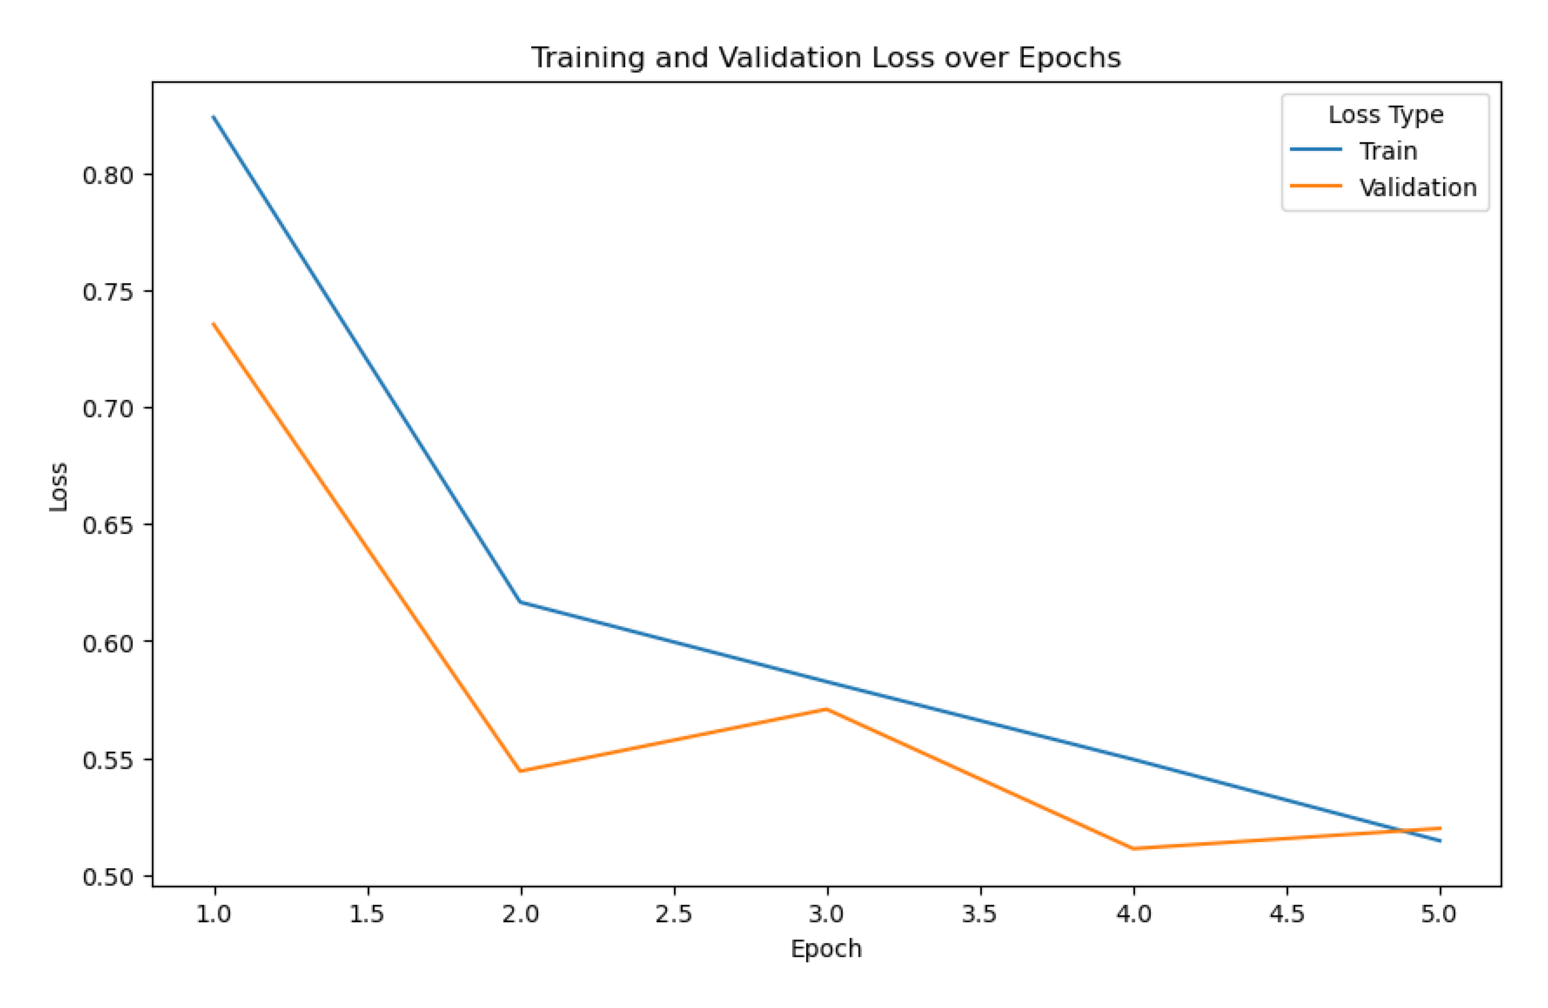

In [5]:
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open('loss.png')

plt.figure(dpi=300)
plt.imshow(img)
plt.axis('off')
plt.show()
